In [ ]:
# Quiet install of required libs
!pip -q install -U langchain-community chromadb sentence-transformers pypdf matplotlib

import json, sys, platform, datetime
import chromadb, sentence_transformers

# Optional CUDA probe
try:
    import torch
    cuda_ok = torch.cuda.is_available()
    device_name = torch.cuda.get_device_name(0) if cuda_ok else "CPU"
except Exception:
    cuda_ok, device_name = False, "CPU"

env = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "cuda": cuda_ok,
    "device": device_name,
    "sentence_transformers": sentence_transformers.__version__,
    "chromadb": chromadb.__version__,
}
print(json.dumps(env, indent=2))
with open("env_rag_trackC_fast.json","w") as f:
    json.dump(env, f, indent=2)


{
  "timestamp": "2025-09-28T01:13:57",
  "python": "3.12.11",
  "platform": "Linux-6.6.97+-x86_64-with-glibc2.35",
  "cuda": true,
  "device": "Tesla T4",
  "sentence_transformers": "5.1.1",
  "chromadb": "1.1.0"
}


In [ ]:
from pathlib import Path
import shutil

CORPUS_DIR = Path("corpus"); CORPUS_DIR.mkdir(exist_ok=True)

# File types to ingest
INGEST_EXTS = {".pdf", ".txt", ".text", ".md"}

# Sweep any loose files in the working directory into corpus/
CWD = Path(".").resolve()
candidates = []
for p in CWD.iterdir():
    if p.is_file() and p.suffix.lower() in INGEST_EXTS and p.parent != CORPUS_DIR:
        candidates.append(p)

print("[sweep] found loose files:", [p.name for p in candidates])
files = []
for p in candidates:
    dest = CORPUS_DIR / p.name
    if dest.exists() and p.resolve() != dest.resolve():
        dest = CORPUS_DIR / f"{p.stem}_copy{p.suffix}"
    # Use Path.rename() to move the file
    p.rename(dest)
    print(f"[sweep] moved {p.name} -> {dest.relative_to(CWD)}")
    files.append(dest)

print("CORPUS contains:", sorted([x.name for x in CORPUS_DIR.iterdir() if x.is_file()]))

[sweep] found loose files: []
CORPUS contains: ['NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf', 'NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf', 'NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf', 'sample.txt']


In [ ]:
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Recursively collect supported files
supported_exts = {".pdf", ".txt", ".text", ".md"}
files = [p for p in CORPUS_DIR.rglob("*") if p.is_file() and p.suffix.lower() in supported_exts]

# If nothing is present, create a tiny fallback so notebook runs
if not files:
    (CORPUS_DIR / "sample.txt").write_text(
        "Topic 1 basics are discussed here. Chart 2 shows trend 2 increasing over time.\n"
        "This small note is only for evaluation plumbing.", encoding="utf-8"
    )
    files = [CORPUS_DIR / "sample.txt"]

print("Found corpus files:", [str(p.relative_to(CORPUS_DIR)) for p in files])

# ---- Load with detailed debug ----
docs = []
for p in files:
    ext = p.suffix.lower()
    try:
        if ext == ".pdf":
            print(f"[load] PDF:  {p}")
            docs.extend(PyPDFLoader(str(p)).load())
        elif ext in {".txt", ".text", ".md"}:
            print(f"[load] TEXT: {p}")
            docs.extend(TextLoader(str(p), encoding="utf-8").load())
        else:
            print(f"[SKIP] {p.name}")
    except Exception as e:
        print(f"[WARN] Could not read {p.name}: {e}")

print(f"[load] total raw docs: {len(docs)}")
if docs:
    print("[load] first doc preview:", (docs[0].page_content or "").replace("\n"," ")[:160])

# ---- Chunking ----
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = splitter.split_documents(docs)

print("✅ Chunks:", len(chunks))
if chunks:
    print("Sample chunk:", chunks[0].page_content[:120].replace("\n"," "))


Found corpus files: ['NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf', 'NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf', 'sample.txt', 'NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf']
[load] PDF:  corpus/NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf
[load] PDF:  corpus/NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf
[load] TEXT: corpus/sample.txt
[load] PDF:  corpus/NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf
[load] total raw docs: 127
[load] first doc preview: Richelieu: Self-Evolving LLM-Based Agents for AI Diplomacy Zhenyu Guan ♢, Xiangyu Kong♣†B, Fangwei Zhong♠†B, Yizhou Wang♡♢ ♢ Institute for Artificial Intelligen
✅ Chunks: 1067
Sample chunk: Richelieu: Self-Evolving LLM-Based A

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings

emb = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectordb = Chroma.from_documents(chunks, emb, persist_directory="chroma_minilm")
retriever = vectordb.as_retriever(search_kwargs={"k": 4})
print("✅ Chroma ready (./chroma_minilm)")


✅ Chroma ready (./chroma_minilm)


In [ ]:
import os, json

EVAL_JSONL_CANDIDATES = [
    "Week5_EvalSet_Template.jsonl",
    "/mnt/data/Week5_EvalSet_Template.jsonl"
]

def ensure_eval_file(path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(json.dumps({
            "qid":"q1",
            "query":"What is topic 1?",
            "gold_answer":"topic 1 basics",
            "gold_source_ids":["doc1","sample","topic","q1"]
        })+"\n")
        f.write(json.dumps({
            "qid":"q2",
            "query":"Explain Chart 2",
            "gold_answer":"trend 2 increasing",
            "gold_source_ids":["img2","chart","sample","q2"]
        })+"\n")

for c in EVAL_JSONL_CANDIDATES:
    if os.path.exists(c):
        EVAL_JSONL = c
        break
else:
    EVAL_JSONL = "Week5_EvalSet_Template.jsonl"
    ensure_eval_file(EVAL_JSONL)

def load_jsonl(p):
    out=[]
    with open(p,"r",encoding="utf-8") as f:
        for line in f:
            if line.strip(): out.append(json.loads(line))
    return out

rows = load_jsonl(EVAL_JSONL)
print(f"✅ Eval rows: {len(rows)} | using: {EVAL_JSONL}")
print(rows[:2])


✅ Eval rows: 6 | using: Week5_EvalSet_Template.jsonl
[{'question': 'Define Valid Response Rate (VRR) in the Trust Game in one line.', 'gold_sources': ['NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf'], 'expected_answer': 'VRR = % personas whose sent amount is within the initial $10 limit.'}, {'question': 'How does trust rate change with probability p in the MAP Trust Game?', 'gold_sources': ['NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf'], 'expected_answer': 'Trust rate increases as risk decreases (higher p).'}]


In [ ]:
import time, re, os
from langchain.schema import Document

# Extract a compact source id from metadata
CAND_SRC_KEYS = ("source","file_path","path","pdf_path","doc_id","id","document_id","filename")
def extract_source_id(meta: dict) -> str:
    for k in CAND_SRC_KEYS:
        v = meta.get(k)
        if v:
            base = os.path.basename(str(v))
            stem = os.path.splitext(base)[0]
            return stem or base
    return meta.get("doc_id") or "source"

def approx_tokens(s: str) -> int:
    return max(1, len((s or "").split()))

def summarize_chunks_simple(docs, max_words=40):
    text = " ".join([(d.page_content or "") for d in docs])[:2000]
    words = re.findall(r"\S+", text)
    return " ".join(words[:max_words])

def run_pipeline(query: str, citations_required: bool = False, k: int = 4):
    t0 = time.perf_counter()
    docs = retriever.get_relevant_documents(query)[:k]
    sources = list(dict.fromkeys([extract_source_id(getattr(d,"metadata",{})) for d in docs if d]))

    # Build a short, deterministic answer from evidence
    evidence_summary = summarize_chunks_simple(docs, max_words=50)
    if not evidence_summary:
        answer = "I cannot find evidence in the corpus."
        sources = []
    else:
        answer = f"From the corpus: {evidence_summary}"

    # Citations required policy
    if citations_required:
        if not sources:
            answer = "I cannot answer with sufficient evidence."
        else:
            # Fix: Use single quotes for the outer f-string
            answer = (answer + " " + " ".join(f'[{s}]' for s in sources)).strip()

    return {
        "answer": answer,
        "sources": sources,
        "latency_s": round(time.perf_counter() - t0, 4),
        "tokens_in": approx_tokens(query),
        "tokens_out": approx_tokens(answer)
    }

# Basic guardrails
PII_PATTERNS = [
    r'\b\d{3}-\d{2}-\d{4}\b',                          # SSN-like
    r'\b\d{3}-\d{3}-\d{4}\b',                          # US phone
    r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}'  # email
]
UNSAFE_HINTS = ["private patient data", "password", "api key", "credit card"]

def redact_pii(text: str) -> str:
    out = str(text)
    for p in PII_PATTERNS:
        out = re.sub(p, "[REDACTED]", out)
    return out

def needs_refusal(q: str) -> bool:
    z = (q or "").lower()
    return any(h in z for h in UNSAFE_HINTS)

def safe_refusal(_: str) -> str:
    return "Sorry, I can’t help with that; it appears unsafe or out of scope."

# Wrap pipeline with guardrails
def guarded_pipeline(query: str, citations_required: bool = False):
    if needs_refusal(query):
        msg = safe_refusal(query)
        return {
            "answer": msg,
            "sources": [],
            "latency_s": 0.0,
            "tokens_in": approx_tokens(query),
            "tokens_out": approx_tokens(msg)
        }
    y = run_pipeline(query, citations_required=citations_required)
    y["answer"] = redact_pii(y["answer"])
    return y

# Quick demo
print(redact_pii("Contact me at a@b.com or 123-456-7890 or 111-22-3333."))
print(guarded_pipeline("Share private patient data", citations_required=True))

Contact me at [REDACTED] or [REDACTED] or [REDACTED].
{'answer': 'Sorry, I can’t help with that; it appears unsafe or out of scope.', 'sources': [], 'latency_s': 0.0, 'tokens_in': 4, 'tokens_out': 13}


In [ ]:
import pandas as pd

def _tok(s: str):
    return re.findall(r"[A-Za-z0-9_]+", (s or "").lower())

def metric_correctness(answer: str, gold: str) -> float:
    if not gold:
        return 0.0
    A, G = set(_tok(answer)), set(_tok(gold))
    return 0.0 if not G else len(A & G) / len(G)

def _norm_ids(ids):
    out = set()
    if not ids:
        return out
    if isinstance(ids, str):
        ids = [ids]
    for g in ids:
        g = (g or "").strip().lower()
        if not g:
            continue
        base = os.path.basename(g)
        stem = os.path.splitext(base)[0]
        out.update([g, base, stem])
    return out

def metric_faithfulness(cited_ids, gold_ids) -> float:
    cited = _norm_ids(cited_ids)
    gold  = _norm_ids(gold_ids)
    return 1.0 if (cited & gold) else 0.0

def eval_system(eval_rows, citations_required=False):
    per=[]
    for r in eval_rows:
        qid  = r.get("qid") or r.get("id") or ""
        q    = r.get("query") or r.get("question") or ""
        gold_ans = r.get("gold_answer") or r.get("expected_answer") or ""
        gold_src = r.get("gold_source_ids") or r.get("gold_sources") or []
        y = guarded_pipeline(q, citations_required=citations_required)
        per.append({
            "qid": qid,
            "query": q,
            "answer": y["answer"],
            "sources": ";".join(y["sources"]),
            "correctness": metric_correctness(y["answer"], gold_ans),
            "faithfulness": metric_faithfulness(y["sources"], gold_src),
            "latency_s": y["latency_s"],
            "tokens_in": y["tokens_in"],
            "tokens_out": y["tokens_out"]
        })
    df = pd.DataFrame(per)
    agg = df.mean(numeric_only=True)
    return df, agg


In [ ]:
before_df, before_s = eval_system(rows, citations_required=False)
after_df,  after_s  = eval_system(rows, citations_required=True)

print("Before:", before_s.to_dict())
print("After :", after_s.to_dict())

before_df.to_csv("trackC_eval_before.csv", index=False)
after_df.to_csv("trackC_eval_after.csv", index=False)
print("Saved: trackC_eval_before.csv, trackC_eval_after.csv")


Before: {'correctness': 0.2094155844155844, 'faithfulness': 1.0, 'latency_s': 0.008733333333333334, 'tokens_in': 10.0, 'tokens_out': 53.0}
After : {'correctness': 0.25405844155844154, 'faithfulness': 1.0, 'latency_s': 0.008983333333333334, 'tokens_in': 10.0, 'tokens_out': 54.0}
Saved: trackC_eval_before.csv, trackC_eval_after.csv


  setting  correctness  faithfulness  latency_s  tokens_in  tokens_out
0  before     0.209416           1.0   0.008733       10.0        53.0
1   after     0.254058           1.0   0.008983       10.0        54.0


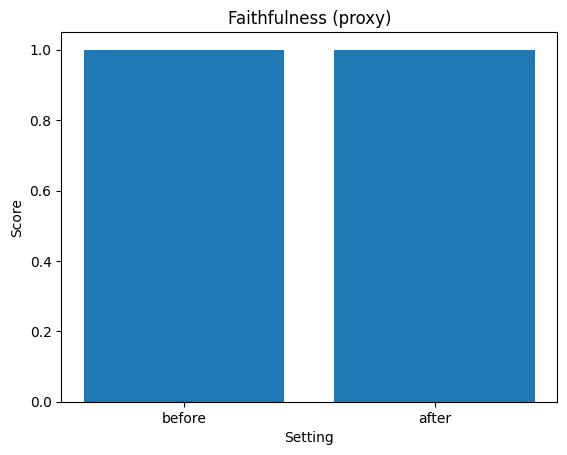

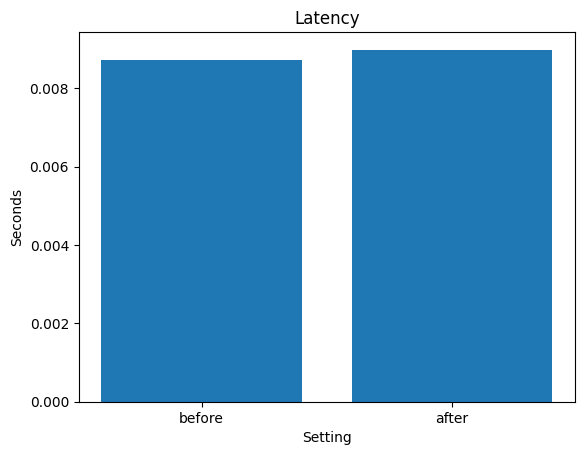

Saved: trackC_eval_summary.csv
Saved: trackC_run_config.json


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd, json, datetime

summary = pd.DataFrame([before_s, after_s], index=["before","after"]).reset_index().rename(columns={"index":"setting"})
print(summary)

plt.figure()
plt.bar(summary["setting"], summary["faithfulness"])
plt.title("Faithfulness (proxy)")
plt.xlabel("Setting"); plt.ylabel("Score")
plt.show()

plt.figure()
plt.bar(summary["setting"], summary["latency_s"])
plt.title("Latency")
plt.xlabel("Setting"); plt.ylabel("Seconds")
plt.show()

summary.to_csv("trackC_eval_summary.csv", index=False)
print("Saved: trackC_eval_summary.csv")

def pv(modname):
    try:
        mod = __import__(modname)
        return getattr(mod, "__version__", "unknown")
    except Exception:
        return "not installed"

run_cfg = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "retriever": {
        "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",
        "chroma_dir": "chroma_minilm",
        "retriever_k": 4,
        "chunking": {"size": 500, "overlap": 100}
    },
    "eval": {
        "eval_jsonl": EVAL_JSONL,
        "before_csv": "trackC_eval_before.csv",
        "after_csv": "trackC_eval_after.csv",
        "summary_csv": "trackC_eval_summary.csv"
    },
    "guardrails": {
        "pii_patterns": ["SSN-like","US phone","email"],
        "unsafe_hints": ["private patient data","password","api key","credit card"]
    },
    "packages": {
        "sentence_transformers": pv("sentence_transformers"),
        "chromadb": pv("chromadb"),
        "matplotlib": pv("matplotlib"),
        "langchain_community": pv("langchain_community")
    }
}
with open("trackC_run_config.json","w") as f:
    json.dump(run_cfg, f, indent=2)
print("Saved: trackC_run_config.json")
